In [16]:
import pandas as pd
import plotly.express as px
import fuzzy_load
import seaborn as sns

In [2]:
def execute_sql(conn, path: str, table_name: str = 'CUSTOMER_TRANSACTIONS') -> pd.DataFrame:
    """
    Execute a SQL query to a table from a file with the connection.

    Args:
        conn: The Snowflake connection object.
        path (str): Path to the sql query.
        table_name (str): The name of the table to create.

    Returns:
        pd.DataFrame: The result from the query.
    """
    with conn.cursor() as cs:
        with open(path, 'r') as file:
            query_template = file.read()
        query = query_template.format(table_name=table_name)
        cs.execute(query)
        sql_result = cs.fetch_pandas_all()
    return sql_result

In [3]:
table_name = "CUSTOMER_TRANSACTIONS"
fuzzy_load.main(table_name=table_name)

Connection to Snowflake established successfully.
Table 'CUSTOMER_TRANSACTIONS' created successfully.
Successfully uploaded 10 rows to CUSTOMER_TRANSACTIONS in 1 chunks.
Connection to Snowflake closed successfully.


In [4]:
conn = fuzzy_load.connect_to_snowflake()

Connection to Snowflake established successfully.


In [ ]:
# Executing queries
dom_df = execute_sql(conn, './sql/day_of_month.sql', table_name)
dow_df = execute_sql(conn, './sql/day_of_week.sql', table_name)
count_dow_df = execute_sql(conn, './sql/day_of_week_count.sql', table_name)

### Plotting the total amount by day of month

From the data we can assume that the total amount being bought increases towards the end of the month

In [6]:
# Plotting the dataframes
dom_df.DAY_OF_MONTH = dom_df.DAY_OF_MONTH.astype(str)
fig = px.bar(
    dom_df,
    x='DAY_OF_MONTH',
    y='TOTAL_AMOUNT',
    title='Total amount per day of month',
    labels={
        'DAY_OF_MONTH': 'Day of month',
        'TOTAL_AMOUNT': 'Total amount'
    },
)
fig.show()

### Plotting the total amount by day of week

Although the pattern is not so obvious on this one, it's safe to assume that on weekends the amount being bought decreases and the days with biggest amount are Tuesday and Friday

In [15]:
fig = px.bar(
    dow_df,
    x='DAY_NAME',
    y='TOTAL_AMOUNT',
    title='Total amount per day of week',
    labels={
        'DAY_NAME': 'Day of week',
        'TOTAL_AMOUNT': 'Total amount'
    },
)
fig.show()

### Plotting the count of transactions by day of week
With this following graph we can further explore the relationship between the buying patterns and the days of the week, we can see that although the weekend seemed to have less transactions, the transactions were actually smaller, and Tuesday and Friday not only have more transactions but their transactions are bigger than the average.

In [14]:
fig = px.bar(
    count_dow_df,
    x='DAY_NAME',
    y='TRANSACTION_COUNT',
    title='Number of transactions per day of week',
    labels={
        'DAY_NAME': 'Day of week',
        'TRANSACTION_COUNT': 'Number of transactions'
    },
)
fig.show()

## Result
There are four patterns that are more evident in the data:
- Most transactions occur on months that have 31 days;

- The data shows a trend in buying towards the end of the month;

- The most common days to buy are Tuesday and Friday;

- On weekends transactions seem to be smaller;

*It's also valid to point out that due to the small amount of data those patterns contain high uncertainty.*

_Instead of using seaborn or matplotlib I opted to use plotly which is a javascript based package which allows dynamic graphs which in my opinion are better to use. But at the end I wrote seaborn code which will be commented out_

Text(0.5, 1.02, 'Number of transactions per day of week')

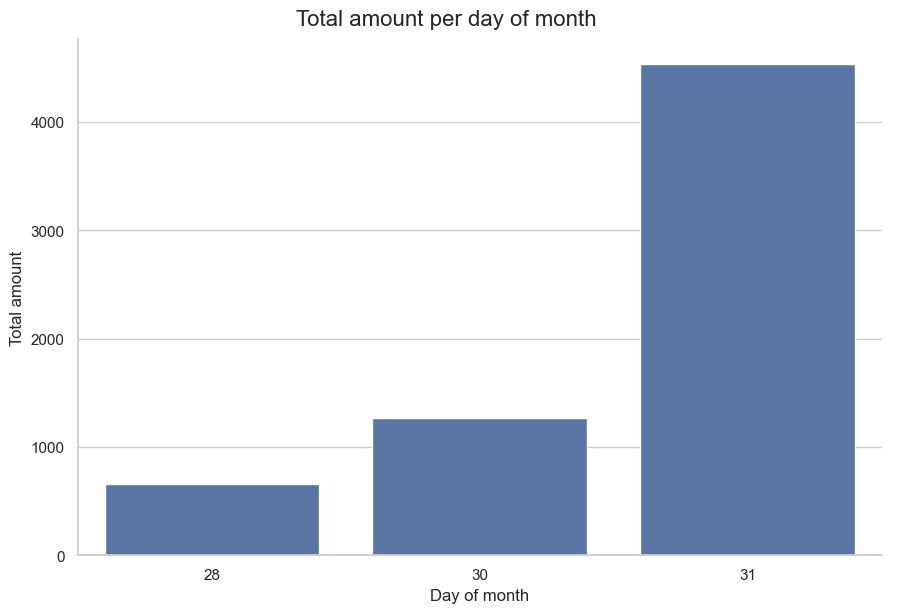

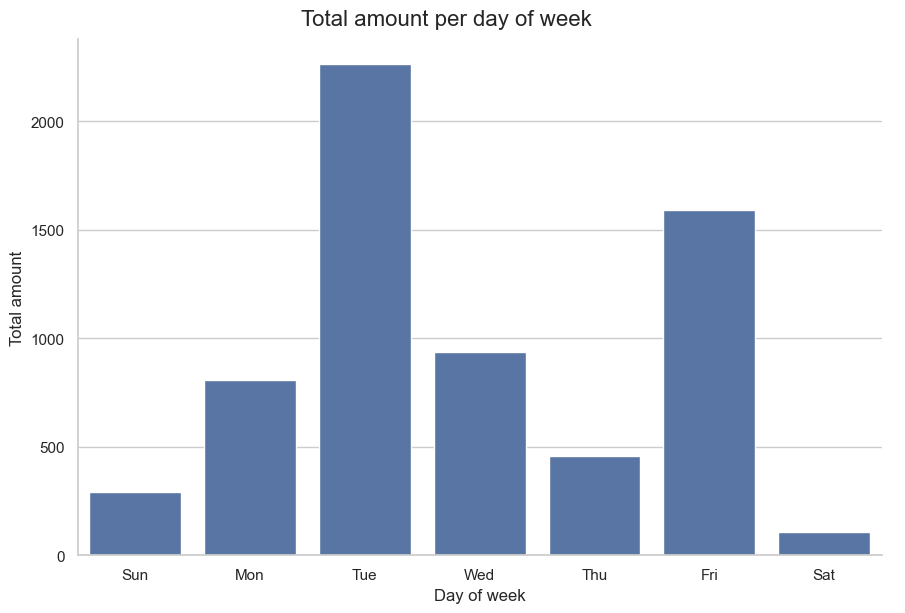

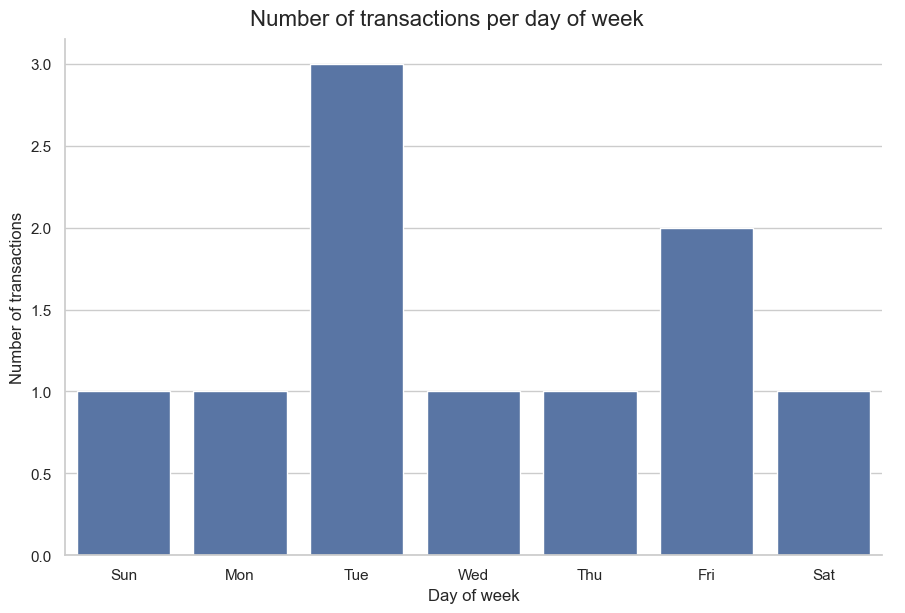

In [ ]:
# sns.set_theme(style="whitegrid")

# bar_plot = sns.catplot(
#     data=dom_df,
#     x="DAY_OF_MONTH",
#     y="TOTAL_AMOUNT",
#     kind="bar",
#     height=6,
#     aspect=1.5
# )

# bar_plot.set_axis_labels("Day of month", "Total amount")
# bar_plot.figure.suptitle("Total amount per day of month", y=1.02, fontsize=16)

# bar_plot = sns.catplot(
#     data=dow_df,
#     x="DAY_NAME",
#     y="TOTAL_AMOUNT",
#     kind="bar",
#     height=6,
#     aspect=1.5
# )

# bar_plot.set_axis_labels("Day of week", "Total amount")
# bar_plot.figure.suptitle("Total amount per day of week", y=1.02, fontsize=16)

# bar_plot = sns.catplot(
#     data=count_dow_df,
#     x="DAY_NAME",
#     y="TRANSACTION_COUNT",
#     kind="bar",
#     height=6,
#     aspect=1.5
# )

# bar_plot.set_axis_labels("Day of week", "Number of transactions")
# bar_plot.figure.suptitle("Number of transactions per day of week", y=1.02, fontsize=16)